In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from scipy import stats

In [2]:
df = pd.read_csv('../data/raw_data/btc.csv', index_col='date')
df.index = pd.to_datetime(df.index)

### Analysis
Charts, stats and some basic feature enginering for checking and undersanting data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2022-05-29 to 2025-02-21
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1000 non-null   float64
 1   high    1000 non-null   float64
 2   low     1000 non-null   float64
 3   close   1000 non-null   float64
 4   volume  1000 non-null   float64
dtypes: float64(5)
memory usage: 46.9 KB


In [4]:
df.index.to_series().diff().value_counts()

date
1 days    999
Name: count, dtype: int64

In [5]:
print(df.describe())

                open           high            low          close  \
count    1000.000000    1000.000000    1000.000000    1000.000000   
mean    44189.234340   45078.153470   43321.171180   44255.382300   
std     25095.061741   25620.886681   24572.246983   25142.203983   
min     15781.290000   16315.000000   15476.000000   15781.290000   
25%     23545.567500   24219.430000   23109.972500   23545.567500   
50%     30516.120000   31304.610000   30177.500000   30556.665000   
75%     63464.007500   64699.500000   62300.500000   63497.250000   
max    106143.820000  109588.000000  105321.490000  106143.820000   

              volume  
count    1000.000000  
mean    96842.036439  
std    117419.572190  
min      7047.904300  
25%     25986.719615  
50%     42457.974300  
75%    121950.872370  
max    760705.362783  


<Axes: xlabel='date'>

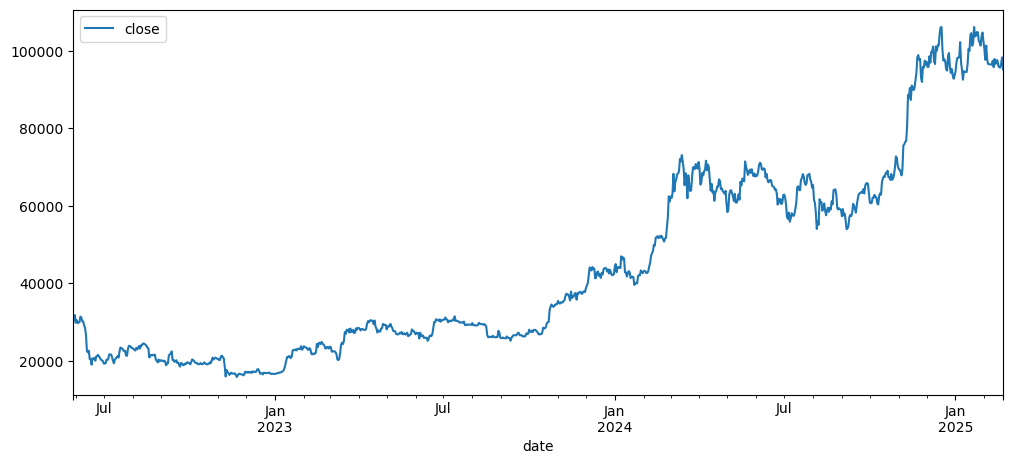

In [6]:
df.plot(y="close", figsize=(12, 5))

<Axes: ylabel='Frequency'>

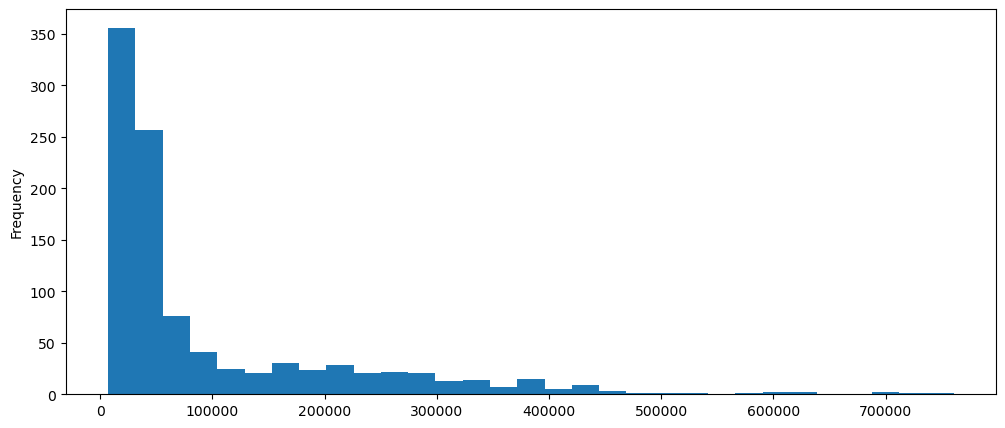

In [7]:
bins=np.sqrt(df.shape[0]).astype(int)
df['volume'].plot(kind = 'hist', bins = bins, figsize=(12, 5))

<Axes: xlabel='date'>

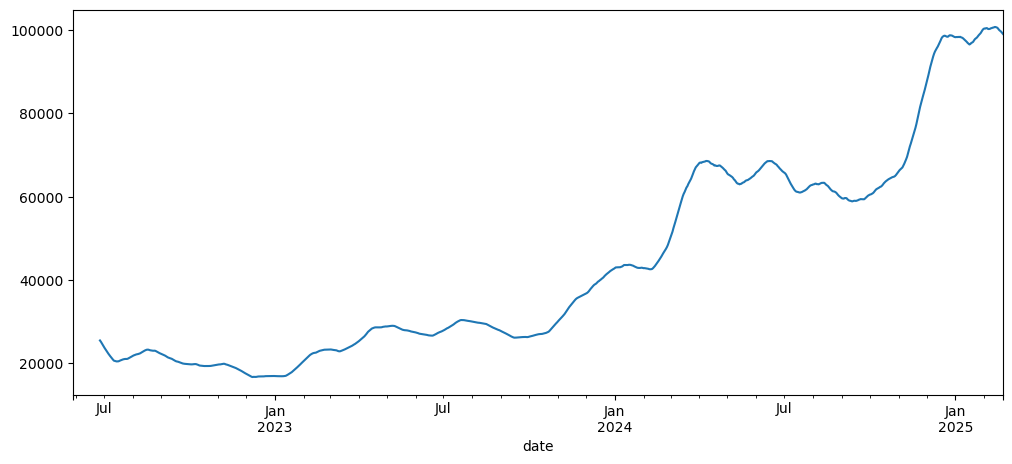

In [8]:
# Moving average
df["close"].rolling(30).mean().plot(figsize=(12,5))

<Axes: xlabel='date'>

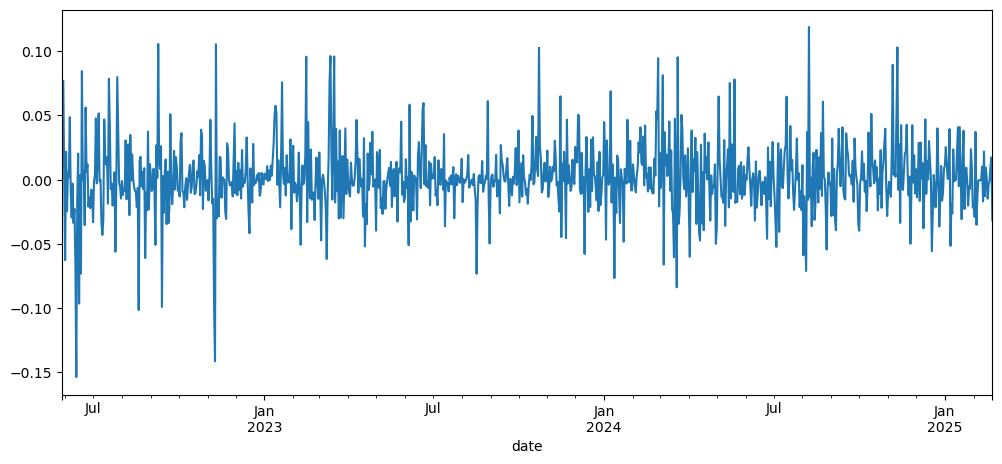

In [9]:
# Daily returns
df['returns'] = df["close"].pct_change()
df['returns'].plot(figsize=(12,5))

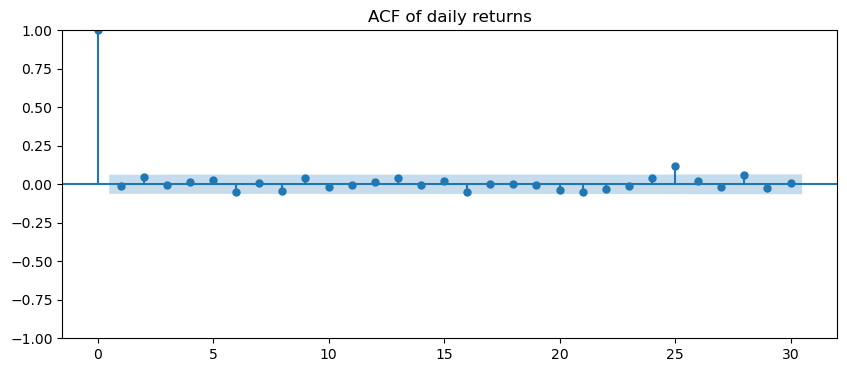

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["returns"].dropna(), ax=ax, lags=30)
ax.set_title("ACF of daily returns")
plt.show()

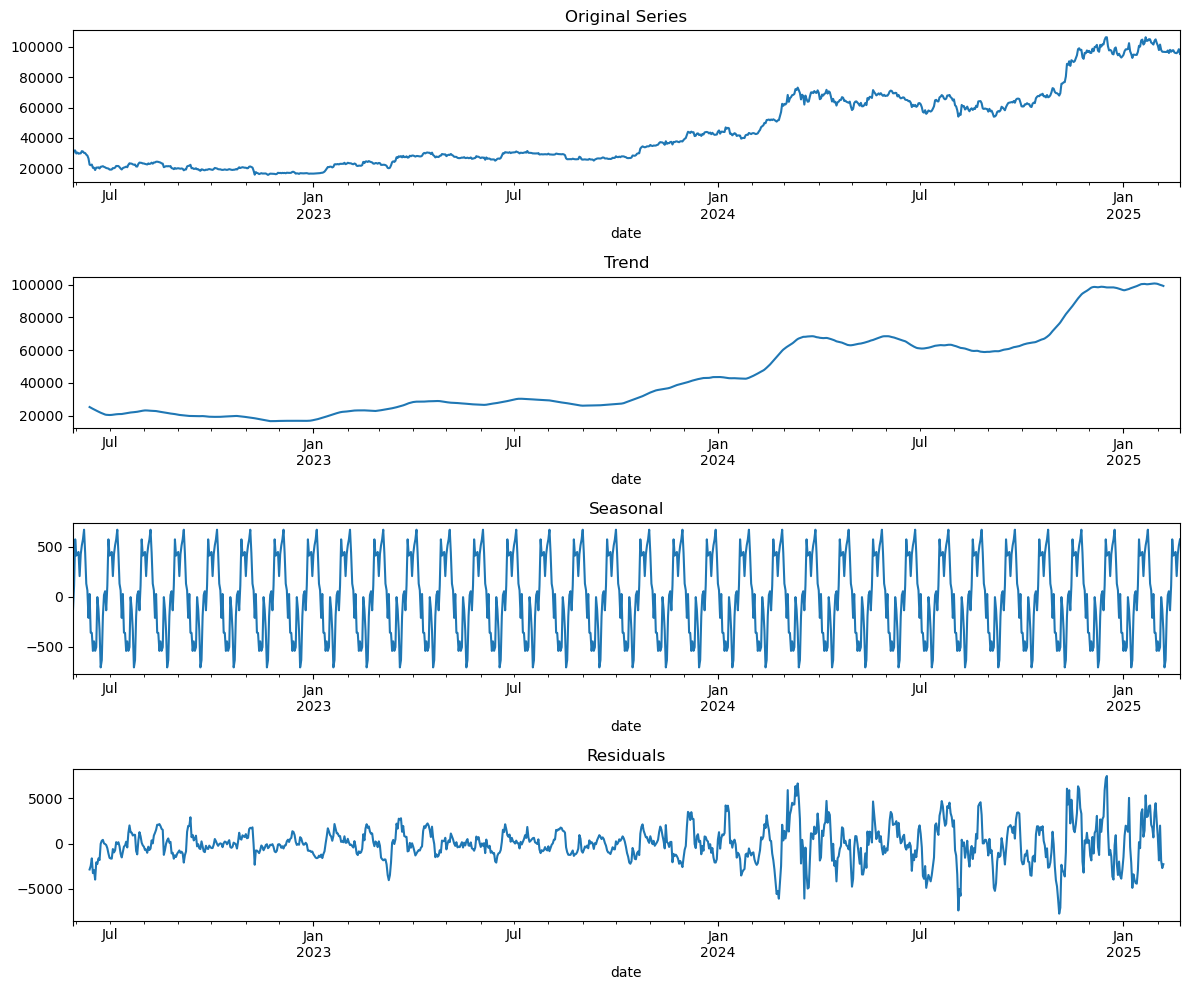

In [11]:
decomp = sm.tsa.seasonal_decompose(df["close"], model="additive", period=30)

fig, axes = plt.subplots(4, 1, figsize=(12, 10))
decomp.observed.plot(ax=axes[0], title='Original Series')
decomp.trend.plot(ax=axes[1], title='Trend')
decomp.seasonal.plot(ax=axes[2], title='Seasonal')
decomp.resid.plot(ax=axes[3], title='Residuals')
plt.tight_layout()
plt.show()

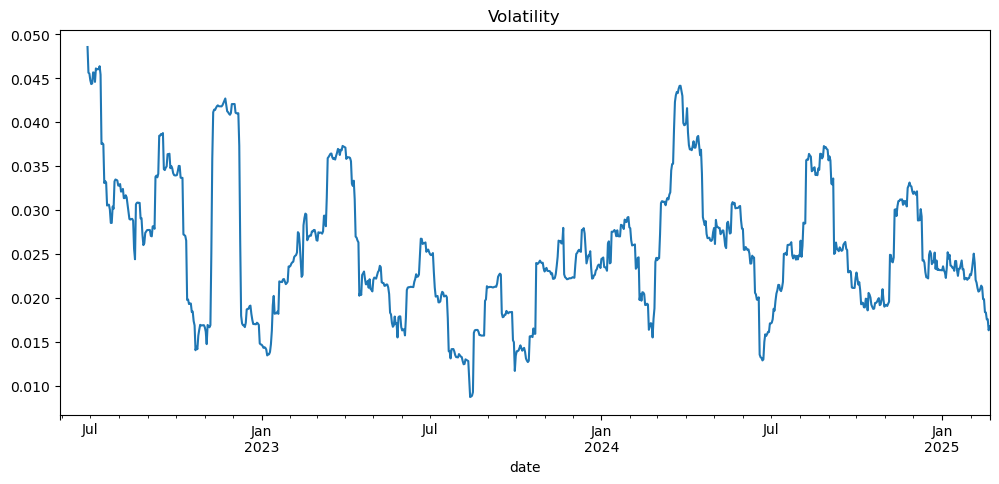

In [12]:
df['volatility'] = df['returns'].rolling(30).std()

fig, ax = plt.subplots(figsize=(12, 5))
df['volatility'].plot(ax=ax, title='Volatility')
plt.show()

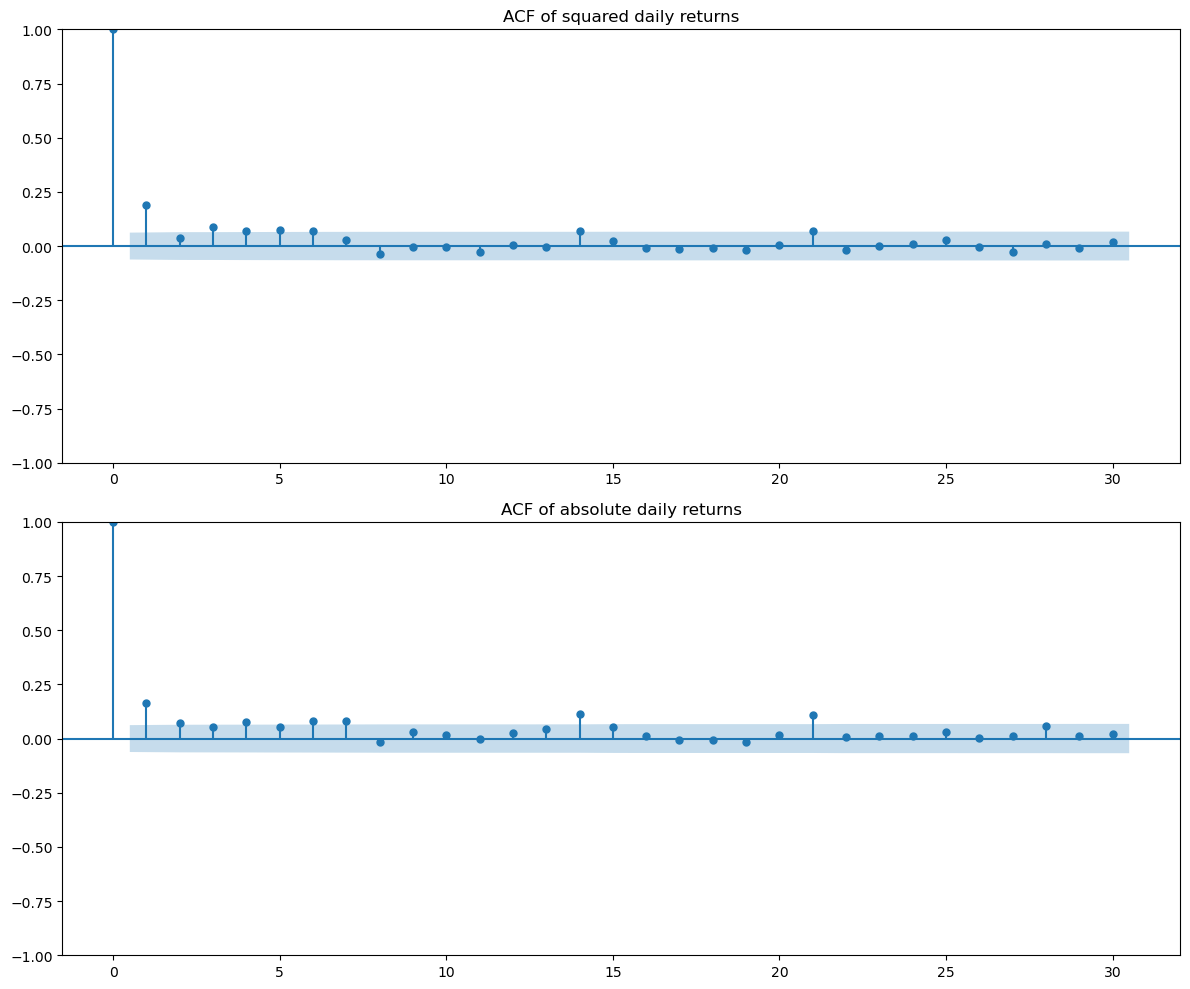

In [13]:
# ACF of absolute daily returns (square)
df['square_returns'] = df['returns']**2
df['abs_returns'] = (df['returns']).abs()

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(df['square_returns'].dropna(), ax=axes[0], lags=30)
axes[0].set_title("ACF of squared daily returns")

plot_acf(df['abs_returns'].dropna(), ax=axes[1], lags=30)
axes[1].set_title("ACF of absolute daily returns")

plt.tight_layout()
plt.show()


### Feature engineering for techincal indicators

In [14]:
# SMA 7, 14, 30
df['sma7'] = df['close'].rolling(7).mean()
df['sma14'] = df['close'].rolling(14).mean()
df['sma30'] = df['close'].rolling(30).mean()

In [15]:
# EMA 7, 14, 30
df['ema7'] = df['close'].ewm(span=7, adjust=False).mean()
df['ema14'] = df['close'].ewm(span=14, adjust=False).mean()
df['ema30'] = df['close'].ewm(span=30, adjust=False).mean()

In [16]:
df['returns_1'] = df['returns'].shift(1)
df['returns_2'] = df['returns'].shift(2)
df['returns_3'] = df['returns'].shift(3)

In [17]:
# Vol SMA 7, 14, 30
df['vol_sma7'] = df['volume'].rolling(window=7).mean()
df['vol_sma14'] = df['volume'].rolling(window=14).mean()
df['vol_sma30'] = df['volume'].rolling(window=30).mean()

In [18]:
# Vol Ratio 7, 14, 30
df['vol_ratio7'] = df['volume'] / df['vol_sma7']
df['vol_ratio14'] = df['volume'] / df['vol_sma14']
df['vol_ratio30'] = df['volume'] / df['vol_sma30']

In [19]:
print(df[['volume', 'vol_sma7', 'vol_sma14', 'vol_sma30', 
    'vol_ratio7', 'vol_ratio14', 'vol_ratio30']].tail(10))

                 volume      vol_sma7     vol_sma14     vol_sma30  vol_ratio7  \
date                                                                            
2025-02-12  29151.16625  21135.627026  26991.652329  30701.575055    1.379243   
2025-02-13  19921.77616  20622.280184  27030.773860  30437.413676    0.966032   
2025-02-14  18173.02646  18676.395300  26758.619898  30026.181499    0.973048   
2025-02-15   7349.37683  18276.700141  26405.649852  29343.398954    0.402117   
2025-02-16   8191.42490  17429.629966  24517.930246  28310.718020    0.469971   
2025-02-17  16492.04510  16846.654213  20327.023574  28050.191857    0.978951   
2025-02-18  23368.19471  17521.001487  19119.895556  27382.555582    1.333725   
2025-02-19  16438.50954  15704.907671  18420.267349  24946.198175    1.046712   
2025-02-20  17057.39177  15295.709901  17958.995043  23983.410567    1.115175   
2025-02-21  29369.56783  16895.215811  17785.805556  24220.773077    1.738336   

            vol_ratio14  vo

### Volume Chart with Technical Indicators
As we are predicting day by day, we will see in the chart that the most fitted for volume will be SMA_7. This feature will probably be useless or give us poor performance, so we will need SMA_14 or SMA_30 because they generalize better.

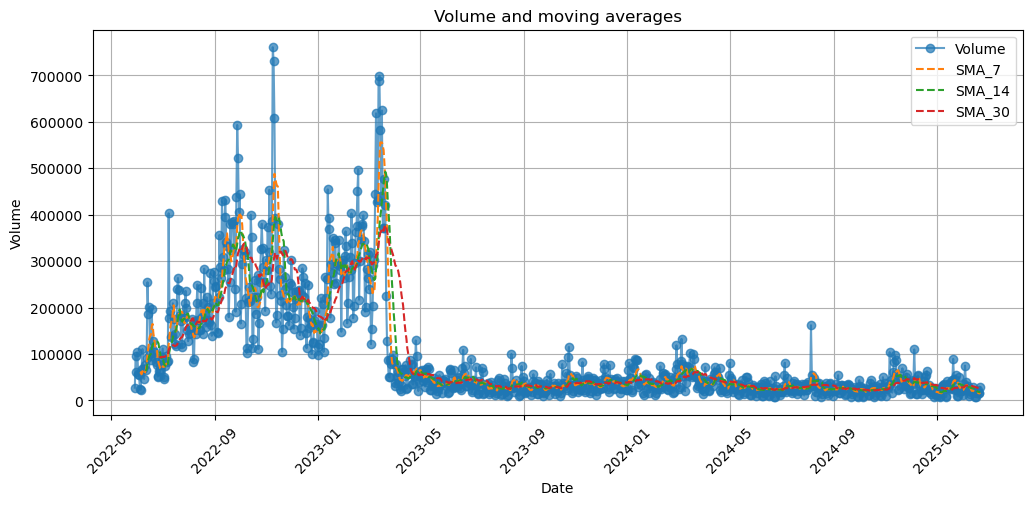

In [ ]:
# Chart 1: Volume and moving averages
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['volume'], label='Volume', linestyle='-', marker='o', alpha=0.7)
plt.plot(df.index, df['vol_sma7'], label='SMA_7', linestyle='--')
plt.plot(df.index, df['vol_sma14'], label='SMA_14', linestyle='--')
plt.plot(df.index, df['vol_sma30'], label='SMA_30', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume and moving averages')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Volume Ratio Chart with Moving Averages

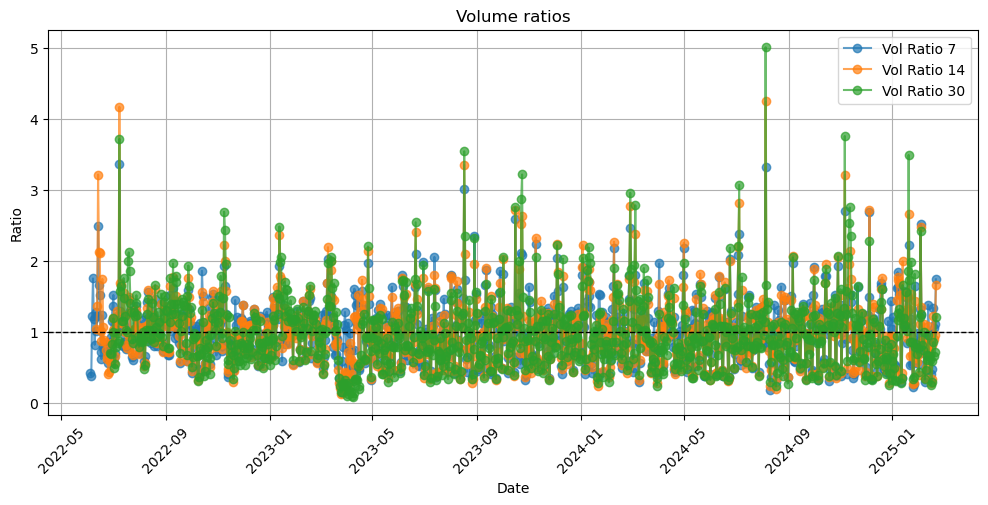

In [ ]:
# Chart 2: Volume ratios
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['vol_ratio7'], label='Vol Ratio 7', linestyle='-', marker='o', alpha=0.7)
plt.plot(df.index, df['vol_ratio14'], label='Vol Ratio 14', linestyle='-', marker='o', alpha=0.7)
plt.plot(df.index, df['vol_ratio30'], label='Vol Ratio 30', linestyle='-', marker='o', alpha=0.7)

plt.axhline(1, color='black', linestyle='--', linewidth=1)  

plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Volume ratios')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

We can observe in the chart that Vol Ratio 7 exhibits high volatility, likely making it less reliable for our predictive model. This feature may introduce too much noise and lead to poor performance. Instead, Vol Ratio 14 and Vol Ratio 30 provide a smoother and more generalized view of volume trends. These longer-term ratios are expected to offer more stable signals and improve the overall accuracy of our predictions by filtering out daily fluctuations and highlighting broader volume patterns.

In [22]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'returns', 'volatility',
       'square_returns', 'abs_returns', 'sma7', 'sma14', 'sma30', 'ema7',
       'ema14', 'ema30', 'returns_1', 'returns_2', 'returns_3', 'vol_sma7',
       'vol_sma14', 'vol_sma30', 'vol_ratio7', 'vol_ratio14', 'vol_ratio30'],
      dtype='object')

### Analysis of Return Columns: Descriptive Statistics and Outlier Detection

This section analyzes the statistical properties of the return columns (`returns`, `returns_1`, `returns_2`, `returns_3`) and identifies potential outliers using two methods: Interquartile Range (IQR) and Z-score.

* **Skewness (skew):** The asymmetry of the return distribution.
* **Kurtosis:** The "tailedness" of the return distribution.

In [23]:
return_cols = ['returns', 'returns_1', 'returns_2', 'returns_3']

for col in return_cols:
    print(f"mean {col}: {df[col].mean()}")
    print(f'median {col}: {df[col].median()}')
    print(f'std {col}: {df[col].std()}')
    print(f'min {col}: {df[col].min()}')
    print(f'max {col}: {df[col].max()}')
    print(f'skew {col}: {df[col].skew()}')
    print(f'kurtosis {col}: {df[col].kurtosis()}')
    print('\n')


# Detecting outliers using IQR
Q1 = df[return_cols].quantile(0.25)
Q3 = df[return_cols].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = ((df[return_cols] < (Q1 - 1.5 * IQR)) | (df[return_cols] > (Q3 + 1.5 * IQR))).sum()
print("Outliers detected using IQR:")
print(outliers_iqr)

# Detecting outliers using Z-score
z_scores = np.abs(stats.zscore(df[return_cols].dropna()))
outliers_zscore = (z_scores > 3).sum(axis=0)
print("\nOutliers detected using Z-score:")
print(outliers_zscore)

mean returns: 0.0015393037613225537
median returns: -0.00013521805068350545
std returns: 0.027036076827955984
min returns: -0.153798392671479
max returns: 0.11883431252058596
skew returns: 0.07179432636261915
kurtosis returns: 4.123095528270921


mean returns_1: 0.0015726943944402393
median returns_1: -0.00011499383846680367
std returns_1: 0.027029015197145064
min returns_1: -0.153798392671479
max returns_1: 0.11883431252058596
skew returns_1: 0.07009272857472182
kurtosis returns_1: 4.135058557881629


mean returns_2: 0.0015570372229623023
median returns_2: -0.00013521805068350545
std returns_2: 0.027038052108699858
min returns_2: -0.153798392671479
max returns_2: 0.11883431252058596
skew returns_2: 0.07164004233203465
kurtosis returns_2: 4.132761882810572


mean returns_3: 0.0015483933597549657
median returns_3: -0.00013544425481504252
std returns_3: 0.027050257386124262
min returns_3: -0.153798392671479
max returns_3: 0.11883431252058596
skew returns_3: 0.0725432667683689
kurtosis re

## More FE

In [24]:
df['cumulative_returns'] = (1 + df['returns']).cumprod()

In [ ]:
"""
    This will be our plan b incase close column performs poorly
is a tipical approach to calculate the price in a time series analysis.
Anyway, log_returns is a powerfull feature because it give the data stability
"""
df['log_returns'] = np.log(df['close']).diff()

In [ ]:
### Calculating Rolling Volatility

"""
    To analyze the changing volatility of our asset's log returns over time, 
we calculate the rolling standard deviation using different window sizes. 
This provides insights into short-term, medium-term, and longer-term volatility trends.
"""
df['rolling_volatility_7'] = df['log_returns'].rolling(7).std()
df['rolling_volatility_14'] = df['log_returns'].rolling(14).std()
df['rolling_volatility_30'] = df['log_returns'].rolling(30).std()

In [27]:
df.dropna(inplace=True)

In [28]:
sns.set(style='whitegrid')

### Distribution of Daily Returns
This visualization displays the distribution of daily returns, providing insights into the frequency and magnitude of price changes. We use a histogram with a kernel density estimate (KDE) to show the shape of the distribution, and a vertical line to indicate the mean return.

c:\Users\santi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


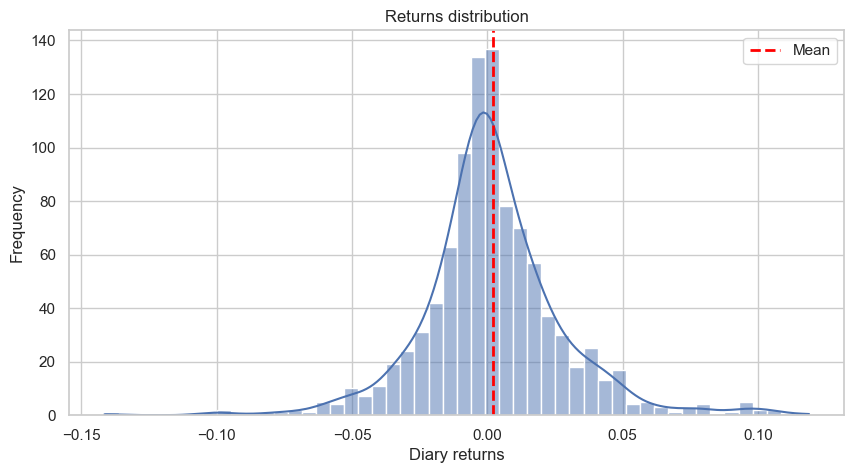

In [29]:
plt.figure(figsize=(10, 5))
sns.histplot(df['returns'], bins=50, kde=True)
plt.axvline(df['returns'].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")
plt.title("Returns distribution")
plt.xlabel("Diary returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## The histogram and KDE plot of daily returns provide several key insights into the asset's price behavior:

* **Central Tendency:**
    * The mean return appears to be very close to zero. This suggests that, on average, the asset's daily returns are neutral.
* **Distribution Shape:**
    * The distribution is roughly symmetrical, suggesting that positive and negative returns are relatively balanced. However, there are some slight deviations from a perfect normal distribution.
    * The peak of the distribution is sharp, indicating that small daily returns are the most frequent.
    * The tails of the distribution are somewhat heavy, suggesting the occurence of some outlier events.
* **Volatility:**
    * The spread of the distribution indicates the volatility of the asset. A wider spread would suggest higher volatility, while a narrower spread indicates lower volatility. In this case there is a medium volatility.
* **Potential Skewness and Kurtosis:**
    * While the distribution appears mostly symmetrical, closer inspection may reveal slight skewness, indicating a bias towards positive or negative returns.
    * The Kurtosis, the "tailedness" of the distribution, can show us how often extreme values appear. If the kurtosis is high, extreme values are more common.

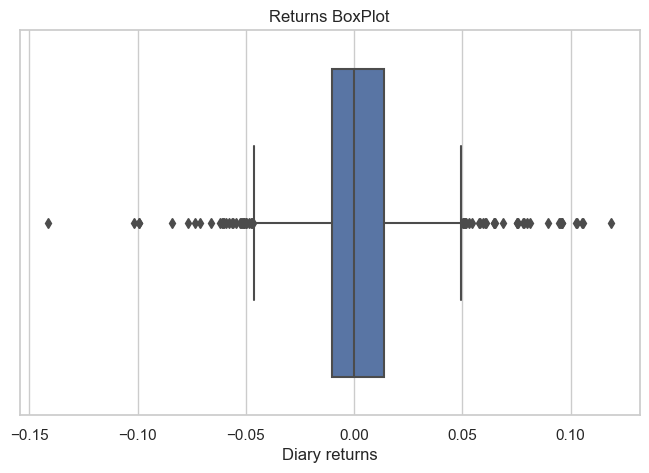

In [ ]:
# Analyzing the outliers for the diary returns
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['returns'])
plt.title("Returns BoxPlot")
plt.xlabel("Diary returns")
plt.show()

* The near-zero median return suggests that the asset's daily returns are generally balanced, with no strong directional bias.
* The narrow IQR indicates that most daily returns are relatively small, suggesting low to medium daily volatility under normal conditions.
* The presence of outliers highlights the risk of occasional large price swings, which could be due to market events or other factors.

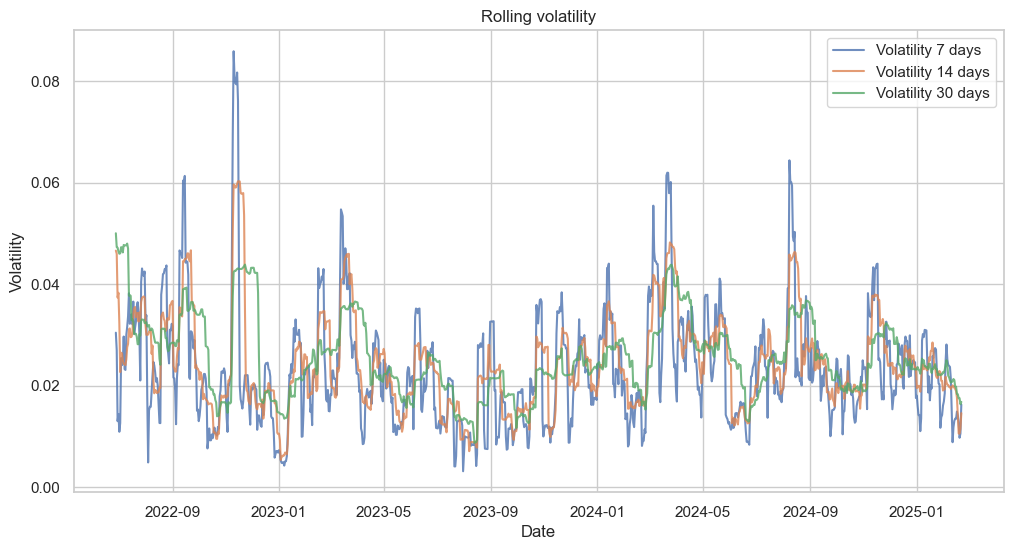

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['rolling_volatility_7'], label='Volatility 7 days', alpha=0.8)
plt.plot(df.index, df['rolling_volatility_14'], label='Volatility 14 days', alpha=0.8)
plt.plot(df.index, df['rolling_volatility_30'], label='Volatility 30 days', alpha=0.8)
plt.title("Rolling volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

### We are checking the volatility by date, as the same with the MA, we will probably end using the volatility 14 or 30 as it provides a more stable and generalized view of the market's volatility trends. Short-term volatility (7 days) might introduce too much noise and lead to less reliable predictions. By focusing on longer-term volatility measures, we aim to capture more meaningful patterns and improve the robustness of our predictive models.

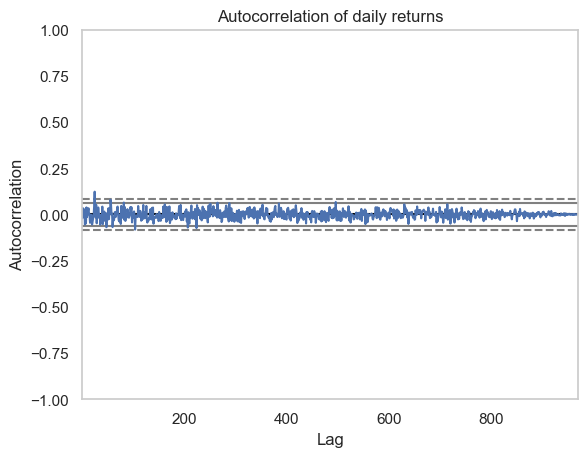

In [32]:
pd.plotting.autocorrelation_plot(df['returns'])
plt.title("Autocorrelation of daily returns")
plt.show()

The lack of significant autocorrelation suggests that daily returns are largely independent of each other. This implies that past returns are not reliable predictors of future returns.
The absence of significant autocorrelation aligns with the weak-form efficient market hypothesis, which states that past price information cannot be used to predict future prices.
The pattern observed suggests that daily returns may follow a random walk, where each day's return is independent of the previous day's return.

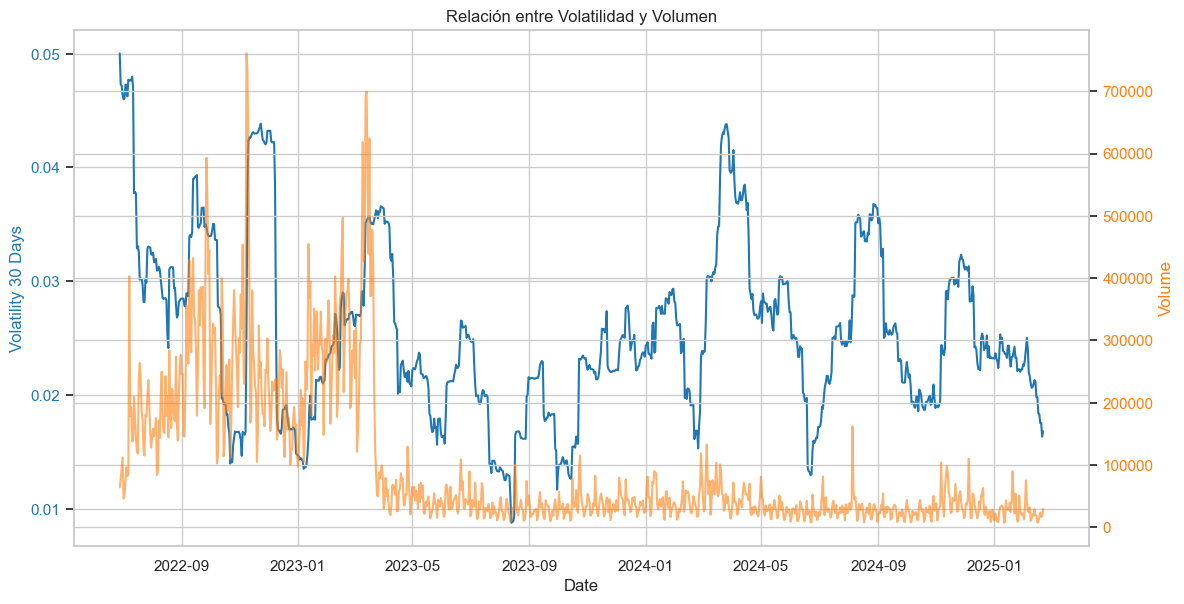

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Date")
ax1.set_ylabel("Volatility 30 Days", color="tab:blue")
ax1.plot(df.index, df["rolling_volatility_30"], color="tab:blue", label="Volatility 30 Days")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Volume", color="tab:orange")
ax2.plot(df.index, df["volume"], color="tab:orange", alpha=0.6, label="Volume")
ax2.tick_params(axis="y", labelcolor="tab:orange")

fig.tight_layout()
plt.title("Relation between Volatilidad y Volumen")
plt.show()

When both features increase simultaneously, it suggests that periods of high price fluctuations are accompanied by increased trading activity.
This often indicates strong market reactions to news or events, as traders rush to buy or sell.

High volatility with low volume might indicate uncertainty without strong conviction from traders.

Spikes in volatilty signify heightened uncertainty and risk. These periods can be associated with significant market events, such as earnings announcements, economic data releases, or geopolitical developments.
Periods of low volatility indicate market stability and reduced price fluctuations.

Sudden increases in volume indicate heightened trading activity. This can suggest strong interest in the asset or significant market movements.
Low volume suggests reduced market participation or a lack of strong conviction among traders.

**Market Sentiment:**
    When both volatility and volume increase, it often confirms the strength of a market trend. This suggests that traders are actively participating in the price movements.
    High volatility with low volume can indicate uncertainty or indecision among traders. They may be reacting to news but are not yet committing to strong positions.

**Increased Risk:**
    Periods of high volatility, especially when accompanied by high volume, signal increased risk. Traders should be cautious during these times.
**Reduced Risk:**
    Low volatility and volume suggest a more stable market environment with reduced risk.

### Now we treat the outliers

In [34]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((df < lower_bound) | (df > upper_bound)).sum()
outlier_counts = outliers.sum()
print(f"Total outliers: {outlier_counts}")

Total outliers: 845


In [35]:
df.describe()

,open,high,low,close,volume,returns,volatility,square_returns,abs_returns,sma7,...,vol_sma14,vol_sma30,vol_ratio7,vol_ratio14,vol_ratio30,cumulative_returns,log_returns,rolling_volatility_7,rolling_volatility_14,rolling_volatility_30
count,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,9.700000e+02,970.000000,970.000000,...,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000
mean,44759.558155,45655.742845,43897.445680,44836.294124,96983.658071,0.001909,0.025523,6.806516e-04,0.017869,44603.253395,...,97430.805430,98147.290588,1.003506,1.002209,0.994441,1.521520,0.001571,0.023272,0.024356,0.025440
std,25253.737616,25787.170434,24712.900209,25293.750097,118848.900816,0.026033,0.007630,1.617283e-03,0.019019,25126.922161,...,106757.041741,102180.239176,0.420604,0.472905,0.516695,0.858343,0.025930,0.011507,0.009411,0.007709
min,15781.290000,16315.000000,15476.000000,15781.290000,7047.904300,-0.141499,0.008730,7.436072e-11,0.000009,16353.032857,...,17498.724934,21417.115930,0.182607,0.127224,0.078277,0.535538,-0.152568,0.003164,0.005399,0.008771
25%,23819.547500,24443.672500,23345.345000,23845.882500,25531.364672,-0.010380,0.020239,2.123107e-05,0.004608,23439.047500,...,29807.116869,30912.487190,0.717315,0.683160,0.654750,0.809210,-0.010434,0.015241,0.018122,0.020001
50%,33907.370000,34731.200000,33535.000000,34001.865000,41109.517935,-0.000115,0.024423,1.388622e-04,0.011784,31784.679286,...,39828.055884,40523.623182,0.979005,0.949970,0.915660,1.153853,-0.000115,0.021629,0.023098,0.024243
75%,63854.002500,65049.995000,62494.707500,63885.530000,125221.805655,0.013783,0.030184,5.746882e-04,0.023973,63655.247500,...,158401.141393,170695.028946,1.222144,1.218048,1.237445,2.167956,0.013689,0.028672,0.028676,0.029625
max,106143.820000,109588.000000,105321.490000,106143.820000,760705.362783,0.118834,0.048550,2.002205e-02,0.141499,104036.882857,...,492610.643974,377643.589109,3.364385,4.243008,5.005963,3.601991,0.112287,0.085851,0.060248,0.050017


In [36]:
df = df.clip(lower=lower_bound, upper=upper_bound, axis=1)
print(df.shape)
print(df.describe())

(970, 29)
                open           high            low          close  \
count     970.000000     970.000000     970.000000     970.000000   
mean    44759.558155   45655.742845   43897.445680   44836.294124   
std     25253.737616   25787.170434   24712.900209   25293.750097   
min     15781.290000   16315.000000   15476.000000   15781.290000   
25%     23819.547500   24443.672500   23345.345000   23845.882500   
50%     33907.370000   34731.200000   33535.000000   34001.865000   
75%     63854.002500   65049.995000   62494.707500   63885.530000   
max    106143.820000  109588.000000  105321.490000  106143.820000   

              volume     returns  volatility  square_returns  abs_returns  \
count     970.000000  970.000000  970.000000    9.700000e+02   970.000000   
mean    86186.261663    0.001573    0.025512    3.898905e-04     0.016671   
std     88856.453700    0.021831    0.007600    4.914864e-04     0.015062   
min      7047.904300   -0.046625    0.008730    7.436072e-11

## Correlations (we will treat them with the model)

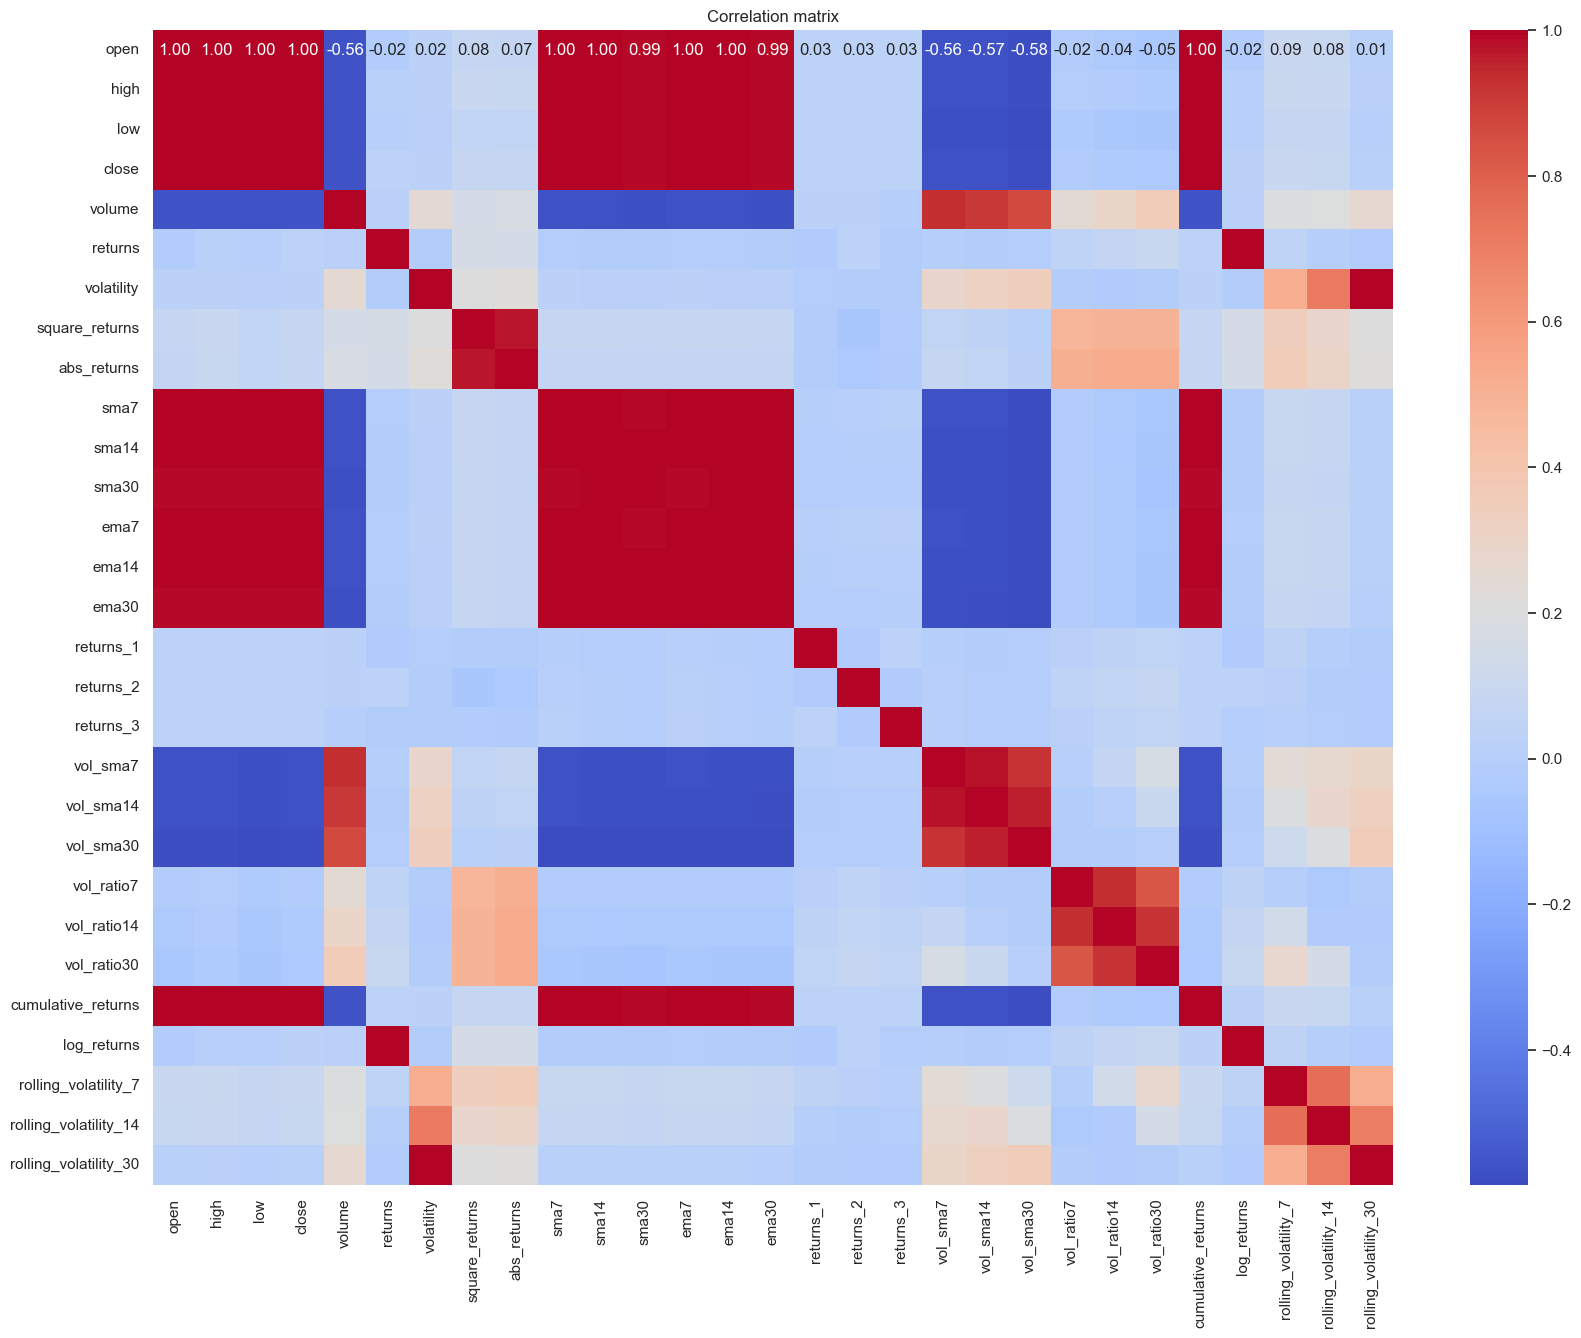

In [37]:
corr_matrix = df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix")
plt.show()

In [38]:
print(df.corr())

                           open      high       low     close    volume  \
open                   1.000000  0.999250  0.999171  0.998647 -0.560709   
high                   0.999250  1.000000  0.998897  0.999480 -0.555430   
low                    0.999171  0.998897  1.000000  0.999264 -0.566474   
close                  0.998647  0.999480  0.999264  1.000000 -0.560305   
volume                -0.560709 -0.555430 -0.566474 -0.560305  1.000000   
returns               -0.016963  0.009339  0.007617  0.028327  0.016180   
volatility             0.022190  0.027288  0.015764  0.022063  0.253692   
square_returns         0.075268  0.092698  0.063052  0.081898  0.152816   
abs_returns            0.067523  0.085300  0.054891  0.073941  0.175124   
sma7                   0.998548  0.998086  0.997814  0.997660 -0.562580   
sma14                  0.995961  0.995374  0.995185  0.994945 -0.564597   
sma30                  0.989478  0.988664  0.988818  0.988329 -0.567597   
ema7                   0.

In [39]:
df.to_csv('../data/processed_data/btc.csv')